# ICESat-2 sea ice tutorial


## 	&#x2B50; Objectives
- Learn how to access/download ICESat-2 sea ice products (ATL07/ATL10/ATL20) via `icepyx` or `earthaccess` libraries.
- Examine what the ICESat-2 sea ice freeboard products (ATL10/ATL20) look like.
- Derive sea ice properties (sea ice thickness, floe size distribution, lead fraction) using ATL10 product.
- Map monthly sea ice freeboard using ATL20 product.

## &#x1F4CC; What is sea ice?
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d8/Sea_ice_Drawing_General_features.svg/1920px-Sea_ice_Drawing_General_features.svg.png" alt="Sea ice" width = "600px">

Sea ice is frozen seawater that floats on the ocean surface. It forms in both the Arctic and the Antarctic in each hemisphere’s winter; it retreats in the summer, but does not completely disappear. Sea ice is not just a "flat" surface. Sea ice surface is very dynamic, so sea ice surface consists of various topograhic features, such as ridges (occur when sea ice floes collide) or leads (open water or thin ice space between sea ice floes). The fine resolution of ICESat-2 allows us to detect the details of these sea ice dynamic features.

## &#x1F4CC; How can laser altimeters measure sea ice freeboard/thickness?
<img src="https://www.mdpi.com/remotesensing/remotesensing-14-01069/article_deploy/html/images/remotesensing-14-01069-g004-550.jpg" alt="ICESat-2 data products" width="400px">

Sea ice freeboard means the height of sea ice surface above **local sea surface**. To calculate sea ice freeboard, it is necessary to subtract local sea surface height from the sea ice height.

$H_{f} = H_{obs} - H_{ssh}$

The **ATL07** product provides the surface height above the reference ellipsoid (WGS84). The ATL07 product aggregates 150 signal photons as a single "height segment", and the mean height of this segment is determined as the surface height. In general, each height segment has 10-20 m of length (strong beams).

Then, in order to calculate sea ice freeboard, it is necessary to separate the height signal from **open water (lead)** and **sea ice surface**. The ATL07 product has its own algorithm to distinguish leads from sea ice.

The **ATL10** product calculates the height difference between sea ice surface and lead surface. The local sea level ($H_{ssh}$) is calculated for every 10 km using detected leads.

## &#x1F4CC; ICESat-2 sea ice products
- <b> ATL07 </b> (sea ice surface heights): Surface height relative to WGS84 ellipsoid. Derived by aggregating 150 signal photons of the ATL03 product. 
- <b> ATL10 </b> (freeboard): Sea ice freeboard calculated from ATL07 product.
- <b> ATL20 </b> (daily/monthly gridded sea ice freeboard): 25-km gridded mean freeboard in daily/monthly scale.

<img src="https://nsidc.org/sites/default/files/images/Data/ICESat2_DataProducts_2023.png" alt="ICESat-2 data products" width="600px">

## &#x2705; Access & Download sea ice products (1) - Use icepyx

In this tutorial, first, we will use `icepyx` library to access and download ICESat-2 datasets.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
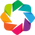

In [11]:
import icepyx as ipx

After importing `icepyx` library, we will create an query to request ICESat-2 data for our region/time of interest.

In [12]:
# Data product: ATL10 (sea ice freeboard)
short_name = 'ATL10'

# Spatial extent: Ross Sea, Antarctica
spatial_extent = [-180, -78, -160, -74]

# Time ragne
# date_range = ['2019-09-16','2019-09-16'] # first time period
date_range = ['2019-11-13','2019-11-13'] # second time period

In [13]:
reg=ipx.Query(short_name, spatial_extent, date_range,
              start_time = "12:00:00", endtime = "20:00:00")

/srv/conda/envs/notebook/lib/python3.10/site-packages/geoviews/operation/__init__.py:14: HoloviewsDeprecationWarning: 'ResamplingOperation' is deprecated and will be removed in version 1.18, use 'ResampleOperation2D' instead.
  from holoviews.operation.datashader import (


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
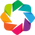

:Overlay
   .WMTS.I :WMTS   [Longitude,Latitude]
   .Path.I :Path   [Longitude,Latitude]

In [14]:
# Visualize the spatial extent
reg.visualize_spatial_extent()

In [15]:
# Check the granule ids
gran_ids = reg.avail_granules(ids=True)
gran_ids

[['ATL10-02_20191113181045_07310501_005_02.h5']]

In [16]:
print(reg.latest_version())
reg.product_summary_info()

005
title :  ATLAS/ICESat-2 L3A Sea Ice Freeboard V005
short_name :  ATL10
version_id :  005
time_start :  2018-10-14T00:00:00.000Z
coordinate_system :  CARTESIAN
summary :  This data set (ATL10) contains estimates of sea ice freeboard, calculated using three different approaches. Sea ice leads used to establish the reference sea surface and descriptive statistics used in the height estimates are also provided. The data were acquired by the Advanced Topographic Laser Altimeter System (ATLAS) instrument on board the Ice, Cloud and land Elevation Satellite-2 (ICESat-2) observatory.
orbit_parameters :  {'swath_width': '36.0', 'period': '96.8', 'inclination_angle': '92.0', 'number_of_orbits': '1.0', 'start_circular_latitude': '0.0'}


In [17]:
# Earthdata login information: Please put your own account information
reg.earthdata_login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
No .netrc found in /home/jovyan


Enter your Earthdata Login username:  younghyunkoo
Enter your Earthdata password:  ········


You're now authenticated with NASA Earthdata Login
Using token with expiration date: 09/11/2023
Using user provided credentials for EDL


In [18]:
# Order granules
reg.order_granules()

Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000004371053
Initial status of your order request at NSIDC is:  pending
Your order status is still  pending  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete


In [19]:
# Download granules
path = "" # you can put your own directory where you want to download the files.
reg.download_granules(path)

Beginning download of zipped output...
Data request 5000004371053 of  1  order(s) is downloaded.
Download complete


## &#x2705; Access & Download sea ice products (2) - Use Earthaccess

Using icepyx, you can download ICESat-2 data for the date and region you are interested in. There is another way to access ICESat-2 data using another Python library `Earthaccess`. In the following Earthaccess example, you can access the raw ICESat-2 data remotely without downloading them to your local machine.

In [24]:
# For searching NASA data
import earthaccess

In [25]:
auth = earthaccess.login()

We are already authenticated with NASA EDL


In [12]:
Query = earthaccess.collection_query().keyword('ICESat-2')

In [13]:
Query.hits()

65

In [14]:
Query = earthaccess.collection_query().keyword('ATL10').cloud_hosted(True)
print(Query.hits())
collections = Query.fields(['ShortName', 'Version']).get(25)
print(collections)

3
[{
  "meta": {
    "concept-id": "C2153574813-NSIDC_CPRD",
    "granule-count": 35693,
    "provider-id": "NSIDC_CPRD"
  },
  "umm": {
    "ShortName": "ATL10",
    "Version": "005"
  }
}, {
  "meta": {
    "concept-id": "C2153577387-NSIDC_CPRD",
    "granule-count": 96,
    "provider-id": "NSIDC_CPRD"
  },
  "umm": {
    "ShortName": "ATL20",
    "Version": "003"
  }
}, {
  "meta": {
    "concept-id": "C2153577500-NSIDC_CPRD",
    "granule-count": 96,
    "provider-id": "NSIDC_CPRD"
  },
  "umm": {
    "ShortName": "ATL21",
    "Version": "002"
  }
}]


In [15]:
Query = earthaccess.granule_query().concept_id(
    'C2153574813-NSIDC_CPRD'
).temporal("2019-11-13 T10:00:00", "2019-11-13 T20:00:00"
).bounding_box(-180, -77, -160, -74)

# Bounding box: [West lon, South lat, East lon, North lat]
# ATL07: C2153574585-NSIDC_CPRD
# ATL10: C2153574813-NSIDC_CPRD
# ATL20: C2153577387-NSIDC_CPRD

In [16]:
Query.hits()

1

In [17]:
granules = Query.get(2)
[display(g) for g in granules];

Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3A Sea Ice Freeboard V005'}
Spatial coverage: {'HorizontalSpatialDomain': {'Orbit': {'AscendingCrossing': 37.764405755246344, 'StartLatitude': -27.0, 'StartDirection': 'D', 'EndLatitude': -27.0, 'EndDirection': 'A'}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2019-11-13T19:14:27.912Z', 'EndingDateTime': '2019-11-13T19:29:10.638Z'}}
Size(MB): 151.16382884979248
Data: ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL10/005/2019/11/13/ATL10-02_20191113181045_07310501_005_02.h5']

In [18]:
files = earthaccess.open(granules)
files

 Opening 1 granules, approx size: 0.15 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

[<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL10/005/2019/11/13/ATL10-02_20191113181045_07310501_005_02.h5>]

## &#x2705; Explore ATL10 sea ice freeboard product (single track)

Now, we will explore what the ATL10 sea ice freeboard data really looks like. Let's start with the two example tracks you downloaded from the previous parts.

### Import necessary libraries

In [2]:
import h5py
import pyproj

# Ignore warning
import warnings
warnings.filterwarnings("ignore")

import cartopy.crs as ccrs

%matplotlib widget
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

### Read first track

In [5]:
# H5 file of the ATL10 track
tutorial_data = "/home/jovyan/shared-public/ICESat-2-Hackweek/sea_ice"
filename = f"{tutorial_data}/processed_ATL10-02_20190916205836_12340401_005_02.h5"

In [6]:
# Check the orbit orientation
with h5py.File(filename,'r') as f:
    orient = f['orbit_info/sc_orient'][0]

# 0: backward; 1: forward; 2: transition (do not use)
print(orient)

1

In [7]:
# Create a list for saving ATL10 beam track data
track = []

with h5py.File(filename,'r') as f:
    
    # Check the orbit orientation
    orient = f['orbit_info/sc_orient'][0]
    
    if orient == 0:
        strong_beams = [f"gt{i}l" for i in [1, 2, 3]]
    elif orient == 1:
        strong_beams = [f"gt{i}l" for i in [1, 2, 3]]
    else:
        strong_beams = []

    for beam in strong_beams:
        
        lat = f[beam]['freeboard_beam_segment/beam_freeboard/latitude'][:]
        lon = f[beam]['freeboard_beam_segment/beam_freeboard/longitude'][:]
        seg_x = f[beam]['freeboard_beam_segment/beam_freeboard/seg_dist_x'][:] / 1000 # (m to km)
        seg_len = f[beam]['freeboard_beam_segment/height_segments/height_segment_length_seg'][:]
        fb = f[beam]['freeboard_beam_segment/beam_freeboard/beam_fb_height'][:]
        surface_type = f[beam]['freeboard_beam_segment/height_segments/height_segment_type'][:]
        fb[fb>100] = np.nan
        
        df = pd.DataFrame({'lat': lat, 'lon': lon, 'seg_x': seg_x, 'seg_len': seg_len,
                          'freeboard': fb, 'stype': surface_type})
        df['beam'] = beam
        df = df.dropna().reset_index(drop = True)
        
        track.append(df)

#### &#x1F50D; Which beam is strong/weak?

The relative location of strong and beak beams depends on the orientation of the satellite orbit. If the satellite moves in forward direction, right beams (i.e., GT1R, GT2R, GT3R) are STRONG beams. On the contrary, in the case of backward direction, left beams (i.e., GT1L, GT2L, GT3L) are WEAK beams.

<img src="https://agupubs.onlinelibrary.wiley.com/cms/asset/9e074a72-2eb9-4457-b6ad-5c57d5334ee5/jgrc23628-fig-0001-m.jpg" alt="Forward Backward" width="600px">


### Draw freeboard histograms

Beam gt1l
   - mean freeboard: 0.482 m
   - std. dev. freeboard: 0.347 m
Beam gt2l
   - mean freeboard: 0.460 m
   - std. dev. freeboard: 0.361 m
Beam gt3l
   - mean freeboard: 0.564 m
   - std. dev. freeboard: 0.378 m


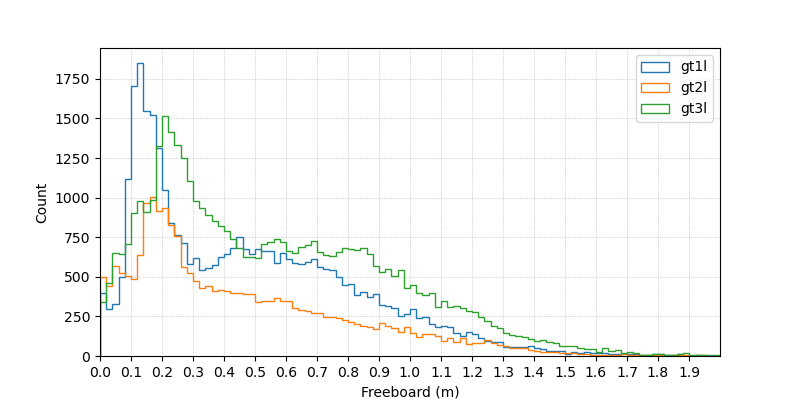

In [20]:
plt.figure(figsize = (8, 4))
for df in track:
    
    plt.hist(df['freeboard'], bins = 100, range = (0,2), label = df.beam[0], histtype = 'step')
    print(f"Beam {df.beam[0]}")
    print(f"   - mean freeboard: {df.freeboard.mean():.3f} m")
    print(f"   - std. dev. freeboard: {df.freeboard.std():.3f} m")
    
plt.xticks(np.arange(0,2,0.1))
plt.xlim(0,2)
plt.grid(ls = ":", lw = 0.5)
plt.legend()
plt.xlabel("Freeboard (m)")
plt.ylabel("Count")
plt.show()

### Draw freeboard track

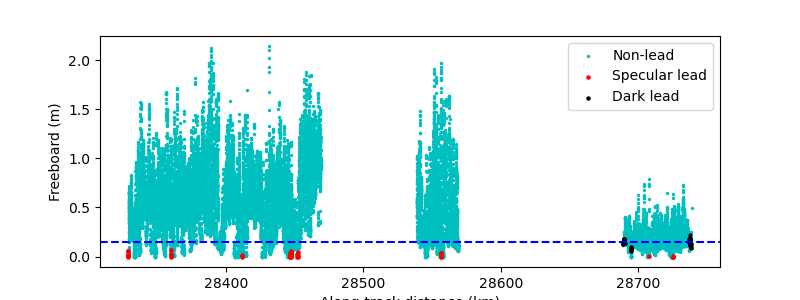

In [21]:
# Select which beam you want to explore (0, 1, 2)
df = track[0]

plt.figure(figsize = (8, 3))

# Masking for normal sea ice
mask_ice = (df.stype == 1)

# Masking for specular lead
mask_specular = (df.stype >= 2) & (df.stype <= 5)

# Masking for dark lead
mask_dark = (df.stype >= 6) & (df.stype <= 9)

plt.scatter(df.seg_x[mask_ice], df.freeboard[mask_ice], s = 2, color = "c", label = "Non-lead")
plt.scatter(df.seg_x[mask_specular], df.freeboard[mask_specular], s = 5, color = "r", label = "Specular lead")
plt.scatter(df.seg_x[mask_dark], df.freeboard[mask_dark], s = 5, color = "k", label = "Dark lead")
plt.axhline(0.15, color = "b", ls = "--")
plt.xlabel("Along-track distance (km)")
plt.ylabel("Freeboard (m)")
plt.legend()

# plt.xlim(32890, 32920)
plt.show()

In [22]:
## Calculate lead fraction
print("Sea ice (%): ", np.sum(df.seg_len[mask_ice]) / np.sum(df.seg_len) * 100)
print("Specular lead (%): ", np.sum(df.seg_len[mask_specular]) / np.sum(df.seg_len) * 100)
print("Dark lead (%): ", np.sum(df.seg_len[mask_dark]) / np.sum(df.seg_len) * 100)
print("Freeboard < 0.15 m (%): ", np.sum(df.seg_len[df.freeboard < 0.15]) / np.sum(df.seg_len) * 100)

Sea ice (%):  99.41918849945068
Specular lead (%):  0.10958740022033453
Dark lead (%):  0.4712196998298168
Freeboard < 0.15 m (%):  21.665985882282257


## &#x1F4A1; Do it yourself!
Let's try the same steps for another track data for the Ross Sea Sea region. The first track we just examined is from September, but this second track is from November. Compare how the freeboard and lead fraction has been changed for these two months.

In [ ]:
tutorial_data = "/home/jovyan/shared-public/ICESat-2-Hackweek/sea_ice"
filename = f"{tutorial_data}/processed_ATL10-02_20191113181045_07310501_005_02.h5"

In [ ]:
# Plot lead fraction, floe size distribution, mean freeboard, etc.

## &#x2705; Explore sea ice freeboard products (gridded product)

Now we will explore gridded sea ice freeboard product (ATL20).

### Antarctic example

We will visualize the Antractic sea ice in September 2021. In general, the Antarctic sea ice extent reaches maximum in September, so you will be able to see the maximum sea ice extent.

In [26]:
# Query Antarctic ATL20 data using earthaccess (September)
Query = earthaccess.granule_query().concept_id(
    'C2153577387-NSIDC_CPRD'
).temporal("2021-09-02", "2021-09-30"
).bounding_box(-180, -90, 180, -60)

granules = Query.get()
granules

[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3B Daily and Monthly Gridded Sea Ice Freeboard V003'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -179.999992, 'EastBoundingCoordinate': 179.999999, 'NorthBoundingCoordinate': -53.516075, 'SouthBoundingCoordinate': -78.481569}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2021-09-01T01:52:44.289Z', 'EndingDateTime': '2021-10-01T00:18:47.822Z'}}
 Size(MB): 0
 Data: ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL20/003/2021/ATL20-02_20210901005050_10601201_003_01.h5']]

In [27]:
# Open file
files = earthaccess.open(granules)
files[0]

 Opening 1 granules, approx size: 0.0 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL20/003/2021/ATL20-02_20210901005050_10601201_003_01.h5>

In [28]:
# Read h5 file
with h5py.File(files[0],'r') as f:
    mean_fb = f['monthly']['mean_fb'][:]
    mean_fb[mean_fb > 1000] = np.nan
    
    # ATL20 is 25 km grid data
    lat = f['grid_lat'][:] # Latitude
    lon = f['grid_lon'][:] # Longitude
    
    # Spatial reference: NSIDC Sea Ice Polar Stereographic South (EPSG:3412)
    x = f['grid_x'][:]
    y = f['grid_y'][:]
    xx, yy = np.meshgrid(x, y)

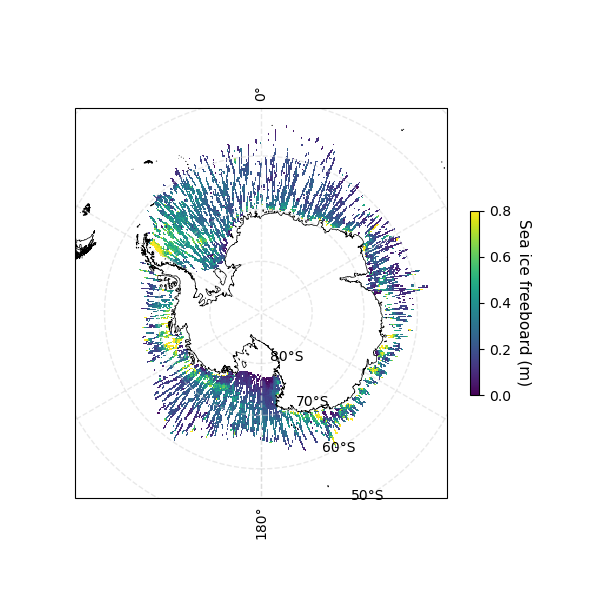

In [29]:
fig=plt.figure(figsize=(6, 6))

# Use the in-built northpolarstereo to visualize (true scale latitude is from NSIDC polar stereographic)
ax = plt.axes(projection = ccrs.SouthPolarStereo(central_longitude=0, true_scale_latitude = -70))

pm  = ax.pcolormesh(xx ,yy, mean_fb, vmin = 0, vmax = 0.8)
ax.coastlines('10m', linewidth = 0.5) # add coastline
# Add gridline
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='lightgrey', alpha=0.5, linestyle='--')

clb = plt.colorbar(pm, ax = ax, shrink = 0.4)
clb.set_label('Sea ice freeboard (m)', rotation = 270, fontsize = 11, va = 'bottom')

### Arctic example

For the Arctic, we will visualize sea ice freeboard map in March 2021.

In [30]:
Query = earthaccess.granule_query().concept_id(
    'C2153577387-NSIDC_CPRD'
).temporal("2021-03-02", "2021-03-30"
).bounding_box(-180, 60, 180, 90)

granules = Query.get()

files = earthaccess.open(granules)

with h5py.File(files[0],'r') as f:
    mean_fb = f['monthly']['mean_fb'][:]
    mean_fb[mean_fb > 1000] = np.nan

    lat = f['grid_lat'][:]
    lon = f['grid_lon'][:]
    
    # Spatial reference: NSIDC Sea Ice Polar Stereographic North (EPSG:3411)
    x = f['grid_x'][:]
    y = f['grid_y'][:]
    xx, yy = np.meshgrid(x, y)

 Opening 1 granules, approx size: 0.0 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

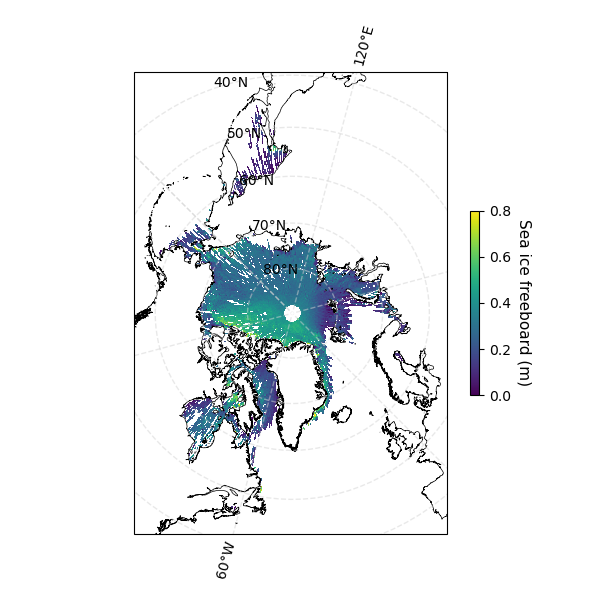

In [31]:
fig=plt.figure(figsize=(6, 6))
# Use the in-built northpolarstereo to visualize (true scale latitude is from NSIDC polar stereographic)
ax = plt.axes(projection = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude = 70))

pm  = ax.pcolormesh(xx ,yy, mean_fb, vmin = 0, vmax = 0.8)
ax.coastlines('10m', linewidth = 0.5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='lightgrey', alpha=0.5, linestyle='--')
clb = plt.colorbar(pm, ax = ax, shrink = 0.4)
clb.set_label('Sea ice freeboard (m)', rotation = 270, fontsize = 11, va = 'bottom')

## &#x1F4A1; Do it yourself!
Let's visualize the griddged freeboard for another month. 

**Credited by Younghyun Koo (kooala317@gmail.com)**